# Homework 1: Montecarlo and TD methods

Let's implement these methods for a simple toy case with discrete and action spaces.

- Implement First-visit Montecarlo for Frozen lake (1p)
- Implement Sarsa and Q-Learning for (1p each)
- How does the value function V look for the different Q functions you found above? You can look at tutorial 3 for ideas how to do this plot. (1p) 

The code below can help you get started with TD. For inspiration about Montecarlo, look at tutorial 3.


In [2]:
import numpy as np
import gym
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
env = gym.make("FrozenLake-v0")

In [3]:
print("Number of states =", env.observation_space.n)
print("Number of actions =", env.action_space.n)

Number of states = 16
Number of actions = 4


In [13]:
env.reset()

0

In [25]:
env.step(1)

(5, 0.0, True, {'prob': 0.3333333333333333})

In [24]:
env.render()

  (Left)
SFFF
FHFH
FFFH
HFFG


In [10]:
space = np.zeros(16,dtype=int)
space[4] = 1
space.reshape(4,4)

array([[0, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [44]:
def epsilon_greedy_policy(Q, epsilon, actions):
    """ 
    Q is a numpy array = qualities of (state, action) pairs, 
    epsilon = prob to choose random action
    1 - eps = prob to choose the action with best Q value = argmax(Q[s][:])
    actions = list of actions
    """
    
    def policy_fn(state):
        if np.random.rand()>epsilon:
            if np.max(Q[state][:]) == 0:
                action = np.random.choice(actions)  # Specific to Frozen Lake, reward cannot be negative.
            else:
                action = np.argmax(Q[state][:])
        else:
            action = np.random.choice(actions)
        return action
    
    return policy_fn

def simulate_best():
    policy = epsilon_greedy_policy(Q, epsilon=0, actions = actions )
    state = env.reset()
    t = 0
    done = False
    space = np.zeros(16,dtype=int)
    env.render()
    while not done:
        t+= 1
        action = policy(state)    
        state, reward, done, _ =  env.step(action)
        if space[state] == 0:
            space[state] = 1
            #print()
            print(space.reshape(4,4))

## First-visit Montecarlo

In [5]:
def run_episode(env, policy): 
    done = False
    state = env.reset()
    episode = []
    while not done:
        action = policy(state)
        new_state, reward, done, _ = env.step(action)
        episode.append((state,action,reward))
        state = new_state    
    return episode # returns list of (state,action,reward)

n_iter = 10000
gamma = 0.99 # discount factor
total_episode_rewards = []

Q = np.zeros([env.observation_space.n, env.action_space.n]) # Q function
R = defaultdict(lambda: np.zeros(env.action_space.n)) # Sum of first-visit rewards of a certain (state, action)
N = defaultdict(lambda: np.zeros(env.action_space.n)) # Number of first-visits of a certain (state, action)
actions = range(env.action_space.n)

for j in tqdm(range(n_iter)):
    # Play 100 episodes randomly, then slowly reduce the randomness
    policy = epsilon_greedy_policy(Q, epsilon=100./(j+1), actions = actions ) 
    
    episode = run_episode(env, policy) # run till losing
    
    ep_reward = sum(x[2]*(gamma**i) for i, x in enumerate(episode)) # episode = list of (state,action,reward)
    #if ep_reward > 0:
    #    print(j, "reward =", ep_reward, "episode=", episode)
    total_episode_rewards.append(ep_reward) # only for logging
    
    # each move in a episode is converted to a tuple of (state, action) to use as dict key
    sa_in_episode = set([(x[0],x[1]) for x in episode]) 
    
    # Find first visit of each (state,action) in the episode
    for s,a in sa_in_episode:
        first_visit = next(i for i,x in enumerate(episode) if x[0]==s and x[1]==a)
        
        G = sum(x[2]*(gamma**i) for i, x in enumerate(episode[first_visit:])) # calc reward from this (s,a) till the end of the episode
        
        R[s][a] += G
        N[s][a] += 1
        Q[s][a] += R[s][a]/N[s][a] # update Q-function

100%|██████████| 10000/10000 [00:04<00:00, 2454.30it/s]


In [6]:
arr = np.array(range(16))
arr.reshape(4,4)

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [7]:
print("Q =\n", Q)
print("Q argmax =\n", np.argmax(Q, axis=1))

Q =
 [[9.92691144e+00 7.72904140e+00 4.56032567e+02 1.20862179e+01]
 [3.32970113e+00 3.06591809e+00 4.12874469e+00 4.61072209e+02]
 [7.63875210e+00 5.57581310e+00 4.81762113e+02 6.39344088e+00]
 [4.89134824e+00 1.26690756e+02 1.65302516e-01 4.76723572e+00]
 [3.71754389e+00 4.94380471e+00 3.67880284e+00 1.58398185e+02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.00109595e+02 7.57460744e+00 3.56861048e+00 8.05798455e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.14150077e-01 1.07867812e+01 2.42572022e-01 0.00000000e+00]
 [5.49324905e-01 3.73061251e+00 2.16455223e+02 3.56454185e-01]
 [5.31921594e+02 2.79964513e+00 1.83635675e+00 1.99563082e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.87680866e+00 2.43985827e+00 2.50736655e+02 2.26531835e+00]
 [1.23583534e+01 5.37322124e+02 6.35410731e+00 9.69740934e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.0

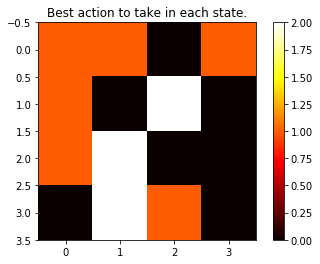

In [28]:
plt.imshow(np.argmax(Q, axis=1).reshape(4,4), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Best action to take in each state.")
plt.show()

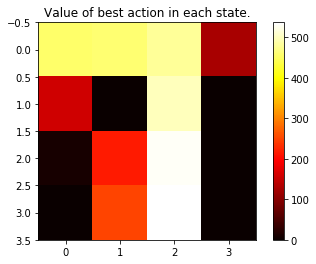

In [8]:
plt.imshow(np.max(Q, axis=1).reshape(4,4), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Value of best action in each state.")
plt.show()

## Sarsa and Q-learning

In [40]:
def sarsa_update(Q, state, action, reward, new_state, new_action):
    Q[state, action] = Q[state, action] + alpha*(reward + gamma*Q[new_state, new_action] - Q[state, action])
    return Q

def Q_learning_update(Q, state, action, reward, new_state, new_action):
    Q[state, action] = Q[state, action] + alpha*(reward + gamma*np.max(Q[new_state, :]) - Q[state, action])
    return Q

actions = range(env.action_space.n)

def run_TD(Q_update):
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    score = [] 

    gamma = 0.99 # discount factor
    alpha = 0.1  # 
    n_episodes = 20000

    for j in range(n_episodes):
        done = False
        state = env.reset()

        # Play randomly 10 episodes, then reduce slowly the randomness
        policy = epsilon_greedy_policy(Q, epsilon=10./(j+1), actions = actions ) 

        ### Generate sample episode
        t=0
        total_reward = 0
        while not done:
            t+=1
            action = policy(state)    
            new_state, reward, done, _ =  env.step(action)
            new_action = policy(new_state)
            total_reward += reward

            #Book-keeping
            Q = Q_update(Q, state, action, reward, new_state, new_action)

            state, action = new_state, new_action

            if done:
                score.append(total_reward)

                if (j+1)%1000 == 0:
                    print("INFO: Episode {} finished after {} timesteps with r={}. \
                    Avg score: {}".format(j+1, t, total_reward, np.mean(score)))
    
    return Q

### Q-learning

In [41]:
Q = run_TD(Q_learning_update)

INFO: Episode 1000 finished after 4 timesteps with r=0.0.                     Avg score: 0.064
INFO: Episode 2000 finished after 11 timesteps with r=0.0.                     Avg score: 0.0775
INFO: Episode 3000 finished after 11 timesteps with r=0.0.                     Avg score: 0.13166666666666665
INFO: Episode 4000 finished after 20 timesteps with r=0.0.                     Avg score: 0.1595
INFO: Episode 5000 finished after 16 timesteps with r=0.0.                     Avg score: 0.1854
INFO: Episode 6000 finished after 8 timesteps with r=0.0.                     Avg score: 0.20666666666666667
INFO: Episode 7000 finished after 8 timesteps with r=0.0.                     Avg score: 0.22428571428571428
INFO: Episode 8000 finished after 8 timesteps with r=0.0.                     Avg score: 0.2345
INFO: Episode 9000 finished after 33 timesteps with r=0.0.                     Avg score: 0.2431111111111111
INFO: Episode 10000 finished after 86 timesteps with r=0.0.                     A

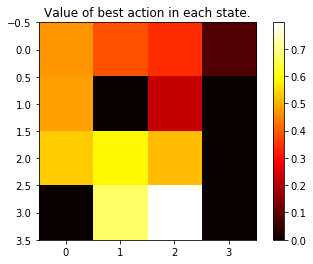

In [42]:
plt.imshow(np.max(Q, axis=1).reshape(4,4), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Value of best action in each state.")
plt.show()

In [45]:
simulate_best()


SFFF
FHFH
FFFH
HFFG
[[1 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
[[1 0 0 0]
 [1 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 0 0]]
[[1 0 0 0]
 [1 0 0 0]
 [1 1 0 0]
 [0 0 0 0]]
[[1 0 0 0]
 [1 0 0 0]
 [1 1 0 0]
 [0 1 0 0]]
[[1 0 0 0]
 [1 0 0 0]
 [1 1 0 0]
 [0 1 1 0]]
[[1 0 0 0]
 [1 0 0 0]
 [1 1 0 0]
 [0 1 1 1]]


### Sarsa

In [46]:
Q = run_TD(sarsa_update)

INFO: Episode 1000 finished after 8 timesteps with r=0.0.                     Avg score: 0.023
INFO: Episode 2000 finished after 7 timesteps with r=0.0.                     Avg score: 0.026
INFO: Episode 3000 finished after 3 timesteps with r=0.0.                     Avg score: 0.042666666666666665
INFO: Episode 4000 finished after 13 timesteps with r=1.0.                     Avg score: 0.06375
INFO: Episode 5000 finished after 22 timesteps with r=0.0.                     Avg score: 0.1058
INFO: Episode 6000 finished after 32 timesteps with r=0.0.                     Avg score: 0.142
INFO: Episode 7000 finished after 15 timesteps with r=1.0.                     Avg score: 0.1692857142857143
INFO: Episode 8000 finished after 11 timesteps with r=0.0.                     Avg score: 0.197
INFO: Episode 9000 finished after 16 timesteps with r=0.0.                     Avg score: 0.22011111111111112
INFO: Episode 10000 finished after 34 timesteps with r=0.0.                     Avg score: 0.2

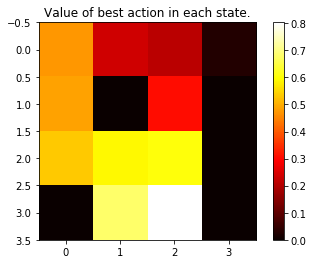

In [47]:
plt.imshow(np.max(Q, axis=1).reshape(4,4), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Value of best action in each state.")
plt.show()

In [48]:
simulate_best()


SFFF
FHFH
FFFH
HFFG
[[1 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
[[1 0 0 0]
 [1 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 0 0]]
[[1 0 0 0]
 [1 0 0 0]
 [1 1 0 0]
 [0 0 0 0]]
[[1 0 0 0]
 [1 0 0 0]
 [1 1 0 0]
 [0 1 0 0]]
[[1 0 0 0]
 [1 0 0 0]
 [1 1 0 0]
 [0 1 1 0]]
[[1 0 0 0]
 [1 0 0 0]
 [1 1 1 0]
 [0 1 1 0]]
[[1 0 0 0]
 [1 0 1 0]
 [1 1 1 0]
 [0 1 1 0]]
[[1 0 0 0]
 [1 0 1 0]
 [1 1 1 0]
 [0 1 1 1]]


In [ ]:
env.close()